In [1]:
#--- imports
from qiskit import *
import numpy as np
import random
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In [2]:
#--- this function creates bernstein-vazirani list for the oracle
def BernsteinVaziraniList(key,number_of_qubits):
    key_binary = format(format(key,'0b'),'0>'+str(number_of_qubits)) 
    plus = [1,1]
    minus = [1,-1] 
    if(key_binary[0]=='0'):
        bv_diagonal = plus
    else:
        bv_diagonal = minus
    
    for x in range(1,number_of_qubits):
        if(key_binary[x]=='0'):
            bv_diagonal = np.kron(bv_diagonal,plus)
        else:
            bv_diagonal = np.kron(bv_diagonal,minus)
        
    return bv_diagonal

#--- this function transforms the previous list into an oracle circuit
def OracleCircuit(oracle_array,number_of_qubits):
    qreg = QuantumRegister(number_of_qubits)
    qc_oracle = QuantumCircuit(qreg,name='Bernstein-Vazirani Oracle')
    qc_oracle.diagonal(oracle_array,qreg)
    qc_oracle = transpile(qc_oracle,basis_gates=['cx','u3'],optimization_level=3)
    return qc_oracle

#--- here we create the bernstein-vazirani circuit: oracle + hadamard transform
def BernsteinvaziraniCircuit(qc_oracle,number_of_qubits):
    qc_bv = QuantumCircuit(number_of_qubits,number_of_qubits)
    qc_bv.h(range(number_of_qubits))
    qc_bv.append(qc_oracle,range(number_of_qubits))
    qc_bv.h(range(number_of_qubits))
    qc_bv.measure(range(number_of_qubits),range(number_of_qubits))
    return qc_bv

#--- running with qasm simulator
def QasmRunning(qc_bv):
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc_bv,backend).result().get_counts()
    return result

#--- running on real backends
def RealRunning(qc_bv,backend_str):
    IBMQ.load_account()
    provider = IBMQ.get_provider(group='open')
    backend = provider.get_backend(backend_str)
    job = execute(qc_bv, backend=backend)
    display(job_monitor(job))
    result = job.result().get_counts()
    return result

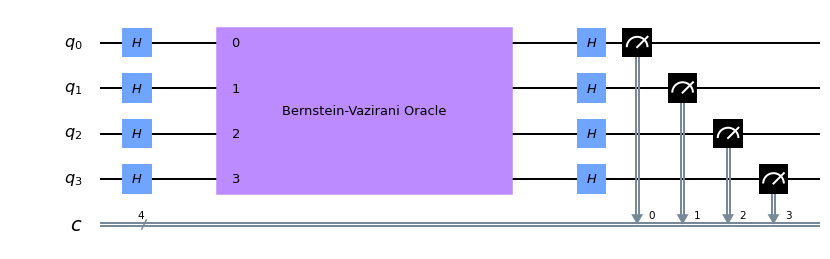

In [3]:
number_of_qubits = 4
key = 3
oracle_list = BernsteinVaziraniList(key,number_of_qubits).tolist()
qc_oracle = OracleCircuit(oracle_list,number_of_qubits)
qc_bv = BernsteinvaziraniCircuit(qc_oracle,number_of_qubits)
display(qc_bv.draw())

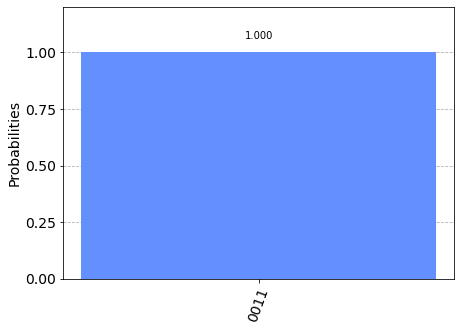

In [4]:
#--- running the circuit with qasm simulator
result_qasm = QasmRunning(qc_bv)
plot_histogram(result_qasm)

Job Status: job has successfully run


None

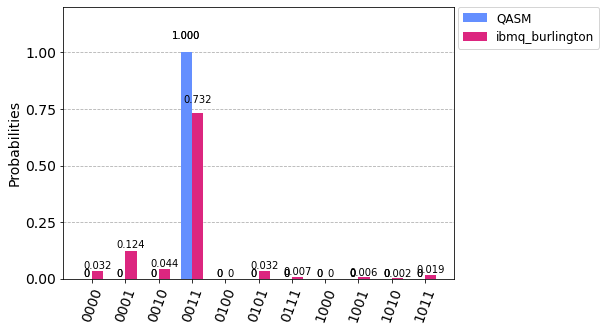

In [5]:
#--- running on real backends
ibm_backend = 'ibmq_burlington'
result_ibm = RealRunning(qc_bv,ibm_backend)
#-- compared results
legend = ['QASM',ibm_backend]
plot_histogram([result_qasm,result_ibm], legend=legend)